In [23]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt


#read players_cleaned
players_cleaned = pd.read_csv('../Player-Clustering/players_cleaned.csv')

#read players_clustered
players_clustered = pd.read_csv('../Player-Clustering/players_clustered.csv')

#read team_cleaned
cleaned_team = pd.read_csv('teams_cleaned.csv')

In [2]:
players_cleaned.head()

,Unnamed: 0,Player,Pos_x,Age_x,Tm_x,G_x,GS,MP_x,FG,FGA,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,as_caliber
0,0,Alex Abrines\abrinal01,SG,24,OKC,75,8,1134,5.0,12.7,...,12.7,1.3,1.0,2.2,0.094,-0.5,-1.7,-2.2,-0.1,0
1,1,Quincy Acy\acyqu01,PF,27,BRK,70,8,1359,4.6,13.0,...,14.4,-0.1,1.1,1.0,0.036,-2.0,-0.2,-2.2,-0.1,0
2,2,Steven Adams\adamsst01,C,24,OKC,76,76,2487,8.9,14.2,...,16.7,6.7,3.0,9.7,0.187,2.2,1.1,3.3,3.3,1
3,3,Bam Adebayo\adebaba01,C,20,MIA,69,19,1368,6.4,12.5,...,15.9,2.3,1.9,4.2,0.148,-1.6,1.8,0.2,0.8,0
4,4,Arron Afflalo\afflaar01,SG,32,ORL,53,3,682,4.7,11.6,...,12.5,-0.1,0.2,0.1,0.009,-4.1,-1.8,-5.8,-0.7,0


In [3]:
#Take out TOT rows, only keep team rows
players = players_cleaned.loc[players_cleaned['Tm_x'] != 'TOT']

#TODO Need to sort on Minutes and only take top 9 per team...
#get set of teams
#for each team in set of teams take top 9s rows of df sorted on min
players_by_team_min = players.sort_values(['Tm_x', 'MP_x'], ascending=[True, False])
top9 = pd.DataFrame()
teams = set(players['Tm_x'])

for i in teams:
    team_df = players_by_team_min[players_by_team_min['Tm_x']==i]
    top9 = top9.append(team_df.iloc[:10,:], ignore_index=True)


#only keep player and team
players = top9[['Player','Tm_x']]

#only keep player and cluster
players_cluster = players_clustered[['Player', 'Cluster']]

In [4]:
#Merge player and team with cluster
player_team_cluster = players.merge(players_cluster, left_on = 'Player', right_on = 'Player', how = 'left')

In [5]:
player_team_cluster.head()

,Player,Tm_x,Cluster
0,Courtney Lee\leeco01,NYK,4
1,Tim Hardaway\hardati02,NYK,4
2,Enes Kanter\kanteen01,NYK,1
3,Frank Ntilikina\ntilila01,NYK,2
4,Michael Beasley\beaslmi01,NYK,3


In [7]:
cluster_dummies = pd.get_dummies(player_team_cluster['Cluster'])

In [8]:
#player_team_cluster_dummies = player_team_cluster.merge(cluster_dummies, left_on = 'Player', right_on = 'Player', how = 'left')
cluster_dummies['Team'] = player_team_cluster['Tm_x']
roster_composition = cluster_dummies.groupby(['Team']).sum()


In [22]:
#add some team stats to this
roster_composition = pd.DataFrame(roster_composition)

Team
ATL    0
BOS    2
BRK    2
CHI    1
CHO    0
CLE    2
DAL    0
DEN    1
DET    4
GSW    1
HOU    4
IND    1
LAC    0
LAL    2
MEM    0
MIA    1
MIL    2
MIN    2
NOP    1
NYK    1
OKC    3
ORL    1
PHI    1
PHO    2
POR    0
SAC    2
SAS    0
TOR    2
UTA    0
WAS    1
Name: 0, dtype: uint8

In [10]:
#PCA CLUSTERING

#DECIDED ON # of Components = 2 to represent 29% of variance
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(roster_composition.select_dtypes(exclude='object'))
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', ])#'principal component 3'])#, 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7'])
np.set_printoptions(precision=2, suppress=True)
print('Total Variance: ' + str(sum(pca.explained_variance_)))
print('Percentage of Var represented by PC: ')
print(pca.explained_variance_/sum(pca.explained_variance_))
print('Cumulative Percentage of Var represented by PC: ')
print(np.cumsum(pca.explained_variance_/sum(pca.explained_variance_)))

Total Variance: 4.139206755572818
Percentage of Var represented by PC: 
[0.56 0.44]
Cumulative Percentage of Var represented by PC: 
[0.56 1.  ]


In [11]:
# principalDf

For n_clusters = 2 The average silhouette_score is : 0.3783997160504123
For n_clusters = 3 The average silhouette_score is : 0.44240459428084683
For n_clusters = 4 The average silhouette_score is : 0.4535493356166779
For n_clusters = 5 The average silhouette_score is : 0.3884988001785203
For n_clusters = 6 The average silhouette_score is : 0.4042542096695556
For n_clusters = 7 The average silhouette_score is : 0.40329940480758125
For n_clusters = 8 The average silhouette_score is : 0.39630591825199707
For n_clusters = 9 The average silhouette_score is : 0.38164872500659486


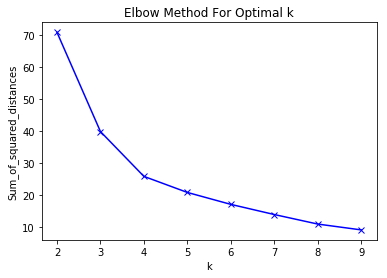

In [12]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(principalDf)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(principalDf, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [13]:
k = 4
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(principalDf)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

principalDf['Team'] = np.array(roster_composition.index)
principalDf['Cluster'] = labels

In [14]:
principalDf

,principal component 1,principal component 2,Team,Cluster
0,-1.235926,-0.517390,ATL,1
1,1.283707,1.966125,BOS,2
2,1.639395,0.399399,BRK,0
3,0.056039,-0.437814,CHI,3
4,-2.213007,0.289159,CHO,1
5,0.594349,-1.405509,CLE,3
6,-0.802945,-0.065628,DAL,1
7,-1.043980,-0.324937,DEN,1
8,2.903779,-0.228211,DET,0
9,-0.552362,3.331251,GSW,2


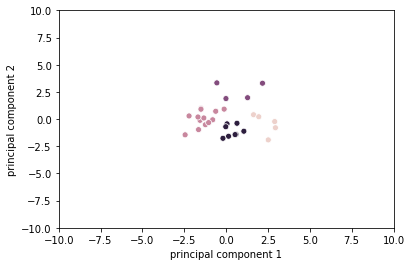

In [15]:
plt.figure()
plt.ylim(-10, 10)
plt.xlim(-10, 10)
sns.scatterplot(x='principal component 1', y ='principal component 2', hue ="Cluster", data = principalDf, legend = False )


In [16]:
principalDf.to_csv('teams_roster_clustered.csv')

In [17]:
principalDf



,principal component 1,principal component 2,Team,Cluster
0,-1.235926,-0.517390,ATL,1
1,1.283707,1.966125,BOS,2
2,1.639395,0.399399,BRK,0
3,0.056039,-0.437814,CHI,3
4,-2.213007,0.289159,CHO,1
5,0.594349,-1.405509,CLE,3
6,-0.802945,-0.065628,DAL,1
7,-1.043980,-0.324937,DEN,1
8,2.903779,-0.228211,DET,0
9,-0.552362,3.331251,GSW,2
